# Extract features

In [38]:
from skimage.feature import hog
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC

def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualize=vis, feature_vector=feature_vec)
        return features

def get_features(root_dir):
    category_map = {'Bike': 0, 'Car': 1}
    hog_features = []
    labels = []

    for category, label in category_map.items():
        category_path = os.path.join(root_dir,category)
        for img_name in tqdm(os.listdir(category_path)):
            img_path = os.path.join(category_path,img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224,224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            hog_feature = get_hog_features(img)
            hog_features.append(hog_feature)
            labels.append(label)
    return np.array(hog_features), np.array(labels)

# Download dataset

In [2]:
# Create Kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the kaggle.json file to the correct location
!mv kaggle.json /root/.kaggle/

# Set permissions for the file
!chmod 600 /root/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d utkarshsaxenadn/car-vs-bike-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset
License(s): CC0-1.0
 86% 88.0M/103M [00:00<00:00, 140MB/s]
100% 103M/103M [00:00<00:00, 121MB/s] 


In [4]:
!unzip car-vs-bike-classification-dataset.zip -d /content/data

Archive:  car-vs-bike-classification-dataset.zip
  inflating: /content/data/Car-Bike-Dataset/Bike/Bike (1).jpeg  
  inflating: /content/data/Car-Bike-Dataset/Bike/Bike (1).jpg  
  inflating: /content/data/Car-Bike-Dataset/Bike/Bike (1).png  
  inflating: /content/data/Car-Bike-Dataset/Bike/Bike (10).jpeg  
  inflating: /content/data/Car-Bike-Dataset/Bike/Bike (10).jpg  
  inflating: /content/data/Car-Bike-Dataset/Bike/Bike (10).png  
  inflating: /content/data/Car-Bike-Dataset/Bike/Bike (100).jpeg  
  inflating: /content/data/Car-Bike-Dataset/Bike/Bike (100).jpg  
  inflating: /content/data/Car-Bike-Dataset/Bike/Bike (1000).jpeg  
  inflating: /content/data/Car-Bike-Dataset/Bike/Bike (1001).jpeg  
  inflating: /content/data/Car-Bike-Dataset/Bike/Bike (1002).jpeg  
  inflating: /content/data/Car-Bike-Dataset/Bike/Bike (1003).jpeg  
  inflating: /content/data/Car-Bike-Dataset/Bike/Bike (1004).jpeg  
  inflating: /content/data/Car-Bike-Dataset/Bike/Bike (1005).jpeg  
  inflating: /content

# Visualize HOG image features

## Ô tô

In [7]:
car_img = cv2.imread('/content/data/Car-Bike-Dataset/Car/Car (1).jpeg')
car_img = cv2.resize(car_img, (224,224))
car_img_gray = cv2.cvtColor(car_img, cv2.COLOR_BGR2GRAY)
feature, car_hog_image = get_hog_features(car_img_gray, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)

(-0.5, 223.5, 223.5, -0.5)

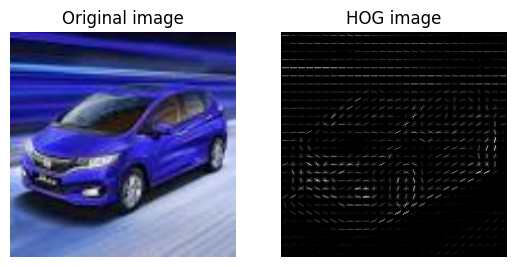

In [11]:
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(car_img)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('HOG image')
plt.imshow(car_hog_image, cmap='gray')
plt.axis('off')

In [13]:
bike_img = cv2.imread('/content/data/Car-Bike-Dataset/Bike/Bike (1).jpg')
bike_img = cv2.resize(bike_img, (224,224))
bike_img_gray = cv2.cvtColor(bike_img, cv2.COLOR_BGR2GRAY)
feature, bike_hog_image = get_hog_features(bike_img_gray, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)

## Xe máy

(-0.5, 223.5, 223.5, -0.5)

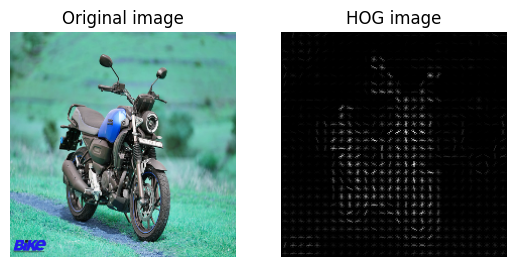

In [14]:
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(bike_img)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('HOG image')
plt.imshow(bike_hog_image, cmap='gray')
plt.axis('off')

In [15]:
features, labels = get_features(root_dir = '/content/data/Car-Bike-Dataset')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
len(features[0])

26244

# Train

## Chia tập train và test

In [17]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(features, labels, test_size=0.2, random_state=42)
len(train_data),len(test_data)

(3200, 800)

## Thực hiện RandomizedSearchCV

In [ ]:
svm = SVC()
param_distributions = {
    'C': np.logspace(-1, 2, 10),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    verbose=1,
    n_jobs=-1
)
random_search.fit(train_data, train_targets)
print("Best parameters:", random_search.best_params_)
print("Best cross-validation accuracy:", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 46.41588833612777}
Best cross-validation accuracy: 0.93625


In [ ]:
results = random_search.cv_results_
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_kernel', 'param_gamma', 'param_degree', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
for mean_score, params in zip(results["mean_test_score"], results["params"]):
  print(mean_score, params)

0.9140625 {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 0.21544346900318834}
0.9118749999999999 {'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'C': 0.46415888336127786}
0.9118749999999999 {'kernel': 'linear', 'gamma': 'auto', 'degree': 3, 'C': 46.41588833612777}
0.9118749999999999 {'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'C': 2.1544346900318834}
0.93625 {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 46.41588833612777}
0.9118749999999999 {'kernel': 'linear', 'gamma': 'auto', 'degree': 4, 'C': 0.1}
0.9118749999999999 {'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'C': 0.21544346900318834}
0.9340624999999999 {'kernel': 'poly', 'gamma': 'scale', 'degree': 4, 'C': 1.0}
0.5068750000000001 {'kernel': 'poly', 'gamma': 'auto', 'degree': 2, 'C': 10.0}
0.9246874999999999 {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 10.0}
0.9118749999999999 {'kernel': 'linear', 'gamma': 'auto', 'degree': 2, 'C': 4.6415888336127775}
0.9118749999999999 {'kernel': 'linear',

## Thực hiện GridSearchCV

In [ ]:
# Define the parameter grid
param_grid = {
    'C': [46.41588833612777, 50, 60, 70, 100],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale'],
    'degree': [2, 3, 4],
}

In [ ]:
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

grid_search.fit(train_data, train_targets)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [46.41588833612777, 50, 60, 70, 100],
                         'degree': [2, 3, 4], 'gamma': ['scale'],
                         'kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [ ]:
results = grid_search.cv_results_
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_degree', 'param_gamma', 'param_kernel', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
for mean_score, params in zip(results["mean_test_score"], results["params"]):
  print(mean_score, params)

0.9371866085469304 {'C': 46.41588833612777, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
0.9324970562083964 {'C': 46.41588833612777, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
0.9371866085469304 {'C': 46.41588833612777, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
0.9356237174944745 {'C': 46.41588833612777, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
0.9371866085469304 {'C': 46.41588833612777, 'degree': 4, 'gamma': 'scale', 'kernel': 'rbf'}
0.9340605333816296 {'C': 46.41588833612777, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}
0.9371866085469304 {'C': 50, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
0.9324970562083964 {'C': 50, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
0.9371866085469304 {'C': 50, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
0.9356237174944745 {'C': 50, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
0.9371866085469304 {'C': 50, 'degree': 4, 'gamma': 'scale', 'kernel': 'rbf'}
0.9340605333816296 {'C': 50, 'degree': 4, 'gamma': 'scale'

# Sử dụng best model tìm được ở GridSearch để dự đoán trên tập test

In [ ]:
best_model = grid_search.best_estimator_

In [34]:
best_model

SVC(C=46.41588833612777, degree=2)

In [40]:
y_pred = best_model.predict(test_data)

In [41]:
print(classification_report(test_targets, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       422
           1       0.94      0.96      0.95       378

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



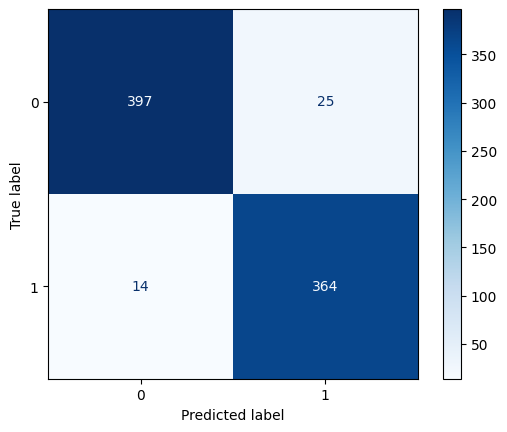

In [42]:
cm = confusion_matrix(test_targets, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_targets))
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
joblib.dump(best_model, 'best_model.pkl')